In [1]:
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import least_squares
from scipy.io import loadmat
import random

In [2]:
def gabor_wave_space_2d(n,sigma,zeta,eta,theta,a,m):
    # generate one gabor wavelet with specified scale and rotation in space
    x = np.arange(-n/2,n/2)
    y = x
    X, Y = np.meshgrid(x,y)
    psi = np.zeros((n,n))

    X_new = a**(-m) * (X * np.cos(theta) + Y * np.sin(theta)); #rotate x and y
    Y_new = a**(-m) * (- X * np.sin(theta) + Y * np.cos(theta));
    # calculate gabor wavelet
    psi = a**(-2 * m) / (2 * math.pi * sigma**2 * zeta)* \
        np.exp((- X_new**2 - (Y_new/zeta)**2)/(2 * sigma**2)) * np.exp(1j * eta * X_new);
    return psi

In [3]:
def gabor_wave_family_space_2d(n,K,Q,S,sigma,zeta,eta,a):
    # generate a family of gabor wavelets with specified scales and rotations in space
    psi = np.zeros((n,n,K,Q*S),dtype=complex)
    
    for i in range(K):
        for k in range(S):
            for l in range(Q):
                psi[:, :, i,k*Q+l] = gabor_wave_space_2d(n,sigma,zeta,eta,i*math.pi/K,a,k+l/Q)
    return psi

In [4]:
def gabor_wave_freq_2d(n, sigma, zeta, eta, a,j,theta):
    # generate one gabor wavelet with specified scale and rotation in frequency
    pi = math.pi
    omega1 = np.linspace(-3*pi, 3*pi-(2*pi)/n, 3*n)
    omega2 = omega1

    omega1,omega2 = np.meshgrid(omega1,omega2)
    omega1_new = omega1 * np.cos(theta) + omega2 * np.sin(theta)
    omega2_new = - omega1 * np.sin(theta) + omega2 * np.cos(theta)

    psi_hat = np.exp(- 1/2 * sigma**2 * (a**j * omega1_new - eta)**2) * \
              np.exp(- 1/2 * sigma**2 * zeta**2 * (a**j * omega2_new)**2)

    psi_add = np.zeros((n,n))
    for i in range(3):
        for k in range(3):
            psi_add = psi_add + psi_hat[i * n :(i + 1) * n ,k * n:(k + 1) * n ]

    return psi_add

In [5]:
def gabor_wave_family_freq_2d(n,K,S,Q,sigma, zeta, eta,a):
    # generate a family of gabor wavelets with specified scales and rotations in frequency
    psi_hat = np.zeros((n,n,K,S*Q), dtype = complex)
    for i in range(K):
        for j in range(S):
            for l in range(Q):
                psi_hat[:,:,i,j*Q+l] = gabor_wave_freq_2d(n,sigma,zeta,eta,a,j+l/Q,i*math.pi/K)
    return psi_hat

In [6]:
def wave_trans_in_space_2d(x, psi):
    # wavelet transform in space
    n = psi.shape[2]
    f = np.zeros(psi.shape,dtype = complex)
    for i in range(n):
        f[:,:,i] = signal.convolve2d(x,psi[:,:,i],'same')
    return f

In [7]:
def pad2d(x, n):
    # pad 2d signal with size n in reflection
    s = x.shape
    
    w0 = min(s[0], n[0])
    a = np.flip(x[0:w0,:],axis = 0)
    b = np.flip(x[s[0] - w0:s[0], :], axis = 0)
    x_bar = np.concatenate((a,x,b), axis = 0)
    
    w1 = min(s[1], n[1])
    c = np.flip(x_bar[:,0:w1], axis = 1)
    d = np.flip(x_bar[:, s[1] - w1:s[1]], axis = 1)
    x_bar = np.concatenate((c,x_bar,d), axis = 1)
    
    return x_bar

In [8]:
def wave_trans_in_freq_2d(x, psi_hat, p):
    # wavelet transform in frequency
    nx = x.shape
    if p:
        x_bar = pad2d(x, nx)
    else:
        x_bar = x
    x_hat = np.fft.fft2(np.fft.fftshift(x_bar))
    f = np.zeros(psi_hat.shape, dtype = complex)
    for i in range(psi_hat.shape[2]):
        f[:,:,i] = np.fft.fftshift(np.fft.ifft2(np.multiply(x_hat,np.fft.fftshift(psi_hat[:,:,i]))))
    if p:
        f = f[nx[0]:2*nx[0], nx[1]:2*nx[1], :]
    return f

In [9]:
def diff(y0, sx, psi_hat, nx):
    # difference vector between first moment wavelet coefficients
    y = np.reshape(y0,nx)
    sy = np.mean(np.abs(wave_trans_in_freq_2d(y, psi_hat, True)), axis = (0,1))
    diff = sy - sx
#     print(np.sum(diff**2))
    return diff

In [10]:
def synthesis(x, psi_hat):
    # synthesis 2d signal x with greedy algorithm
    sx = np.mean(np.abs(wave_trans_in_freq_2d(x, psi_hat, True)),axis = (0,1))
    nx = x.shape
    y0 = np.random.random(nx[0]*nx[1])  # initialize y
    nw = psi_hat.shape[2]  # number of wavelets 
    ind = range(nw)
    ind = random.sample(ind,len(ind))
    
    for i in range(nw):
#         print(i)
        y = least_squares(diff, y0, args = (sx[ind[0:i+1]], psi_hat[:,:,ind[0:i+1]],nx))
        print(y.cost)
        y0 = y.x
    return y

In [11]:
x = loadmat('/Users/kejiqing/Desktop/research/wavelet&EMD/code/images/mydata.mat')
x = x['mydata']
#x of size 640 x 640 x 111

In [12]:
#parameters tp define wavelets
pi = math.pi
n = 32
K = 6
S = 4
Q = 2
sigma = 1.1
zeta = 1.2
eta = 0.8 * pi
a = 2
j = 2
theta = math.pi/6
psi = gabor_wave_family_space_2d(n,K,Q,S,sigma,zeta,eta,a)
psi_hat = gabor_wave_family_freq_2d(3*n,K,S,Q,sigma, zeta, eta,a) #for padded image

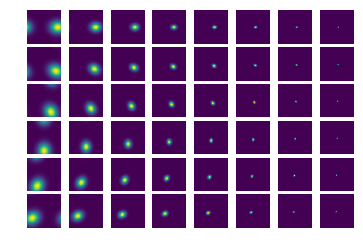

In [13]:
# real parts of wavelets in frequency
count = 0
for i in range(K):
    for k in range(S*Q):
        count += 1
        plt.subplot(K,S*Q,count)
        plt.imshow(np.real(psi_hat[:,:,i,k]))
        plt.axis('off')
plt.subplots_adjust(hspace=0.1, wspace=0)
plt.show()

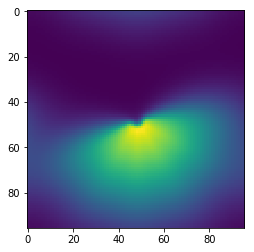

In [14]:
# real part of sum of wavelets
plt.imshow(np.real(np.sum(psi_hat, axis = (2,3))))

In [15]:
# reshape the family of wavelets 
npsi = psi.shape
psi = np.reshape(psi,(npsi[0], npsi[1], npsi[2]*npsi[3]))
npsi_hat = psi_hat.shape
psi_hat = np.reshape(psi_hat,(npsi_hat[0], npsi_hat[1], npsi_hat[2]*npsi_hat[3]))

0
5.391370095259274e-13


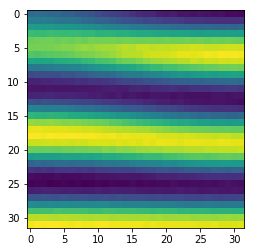

1
2.9298719688718684e-11


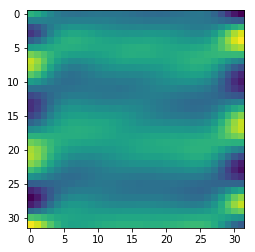

2
5.152574897240115e-12


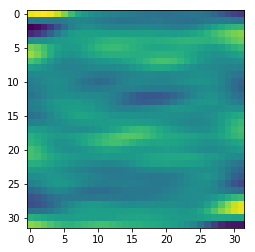

3
5.614108514799971e-12


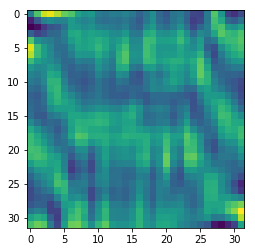

4
1.877569906800976e-12


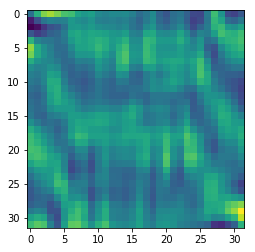

5
1.1990072214961505e-11


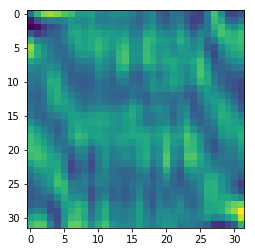

6
1.8587532251627544e-13


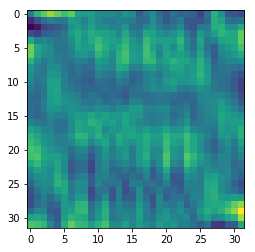

7
1.402889893191879e-10


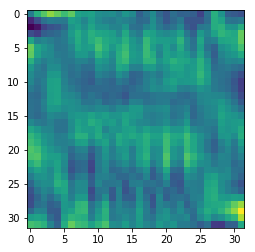

8
1.9062769710551596e-13


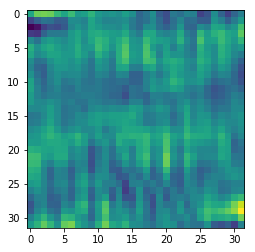

9
2.022546032290334e-11


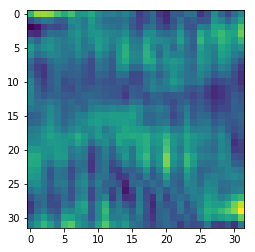

10
4.142653098302112e-15


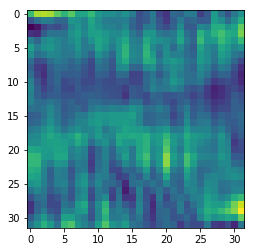

11
8.735644410105119e-11


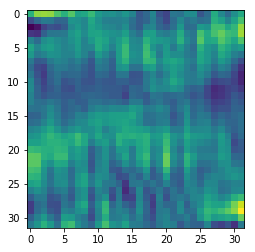

12
7.88821725769006e-11


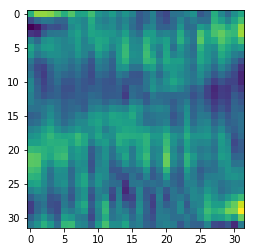

13
8.833177781893567e-12


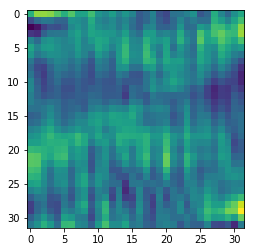

14
1.822981085577365e-14


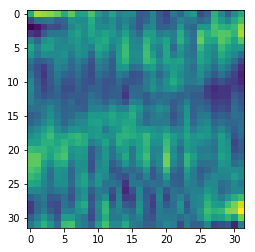

15
3.1877214964491656e-11


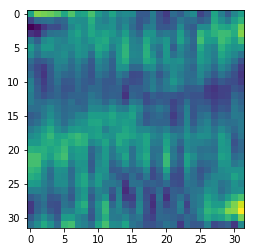

16
3.0077534841296146e-12


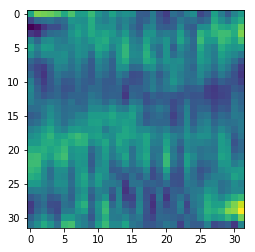

17
8.016194334335514e-11


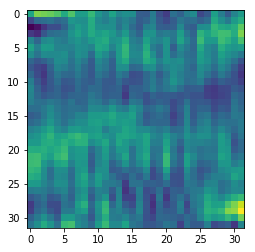

18
2.3227692045369295e-11


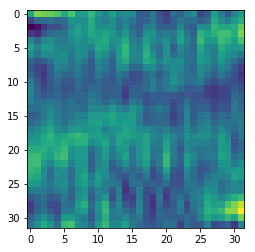

19
1.8752798754982745e-10


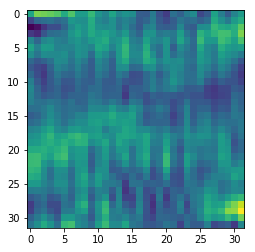

20
4.894321088800742e-11


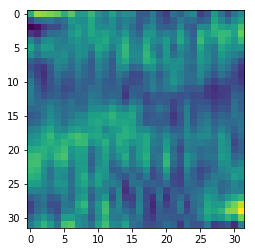

21
2.737475146340813e-10


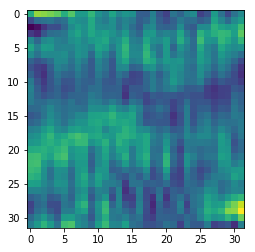

22
6.947720596115879e-10


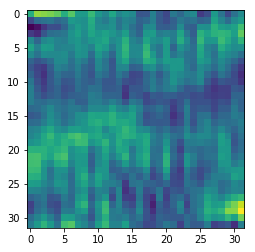

23
5.112321672108362e-10


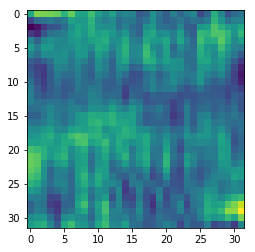

24
2.2772087757028005e-11


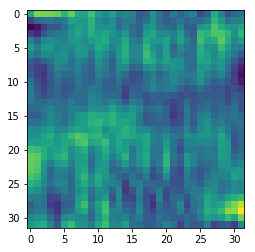

25
3.9264291507576706e-12


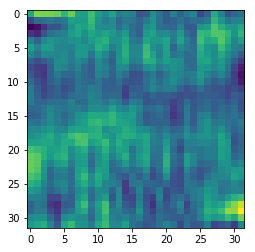

26
2.2804861760137178e-11


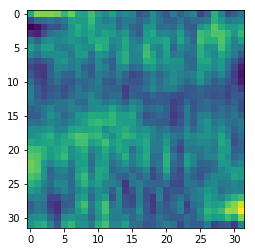

27
1.7388118802162887e-10


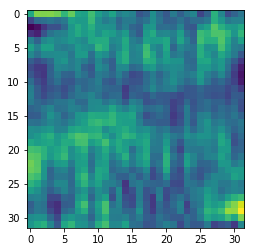

28
4.661559722429759e-11


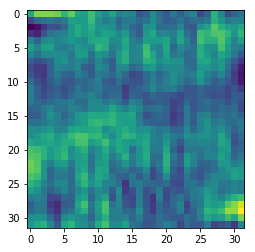

29
7.580034630871812e-12


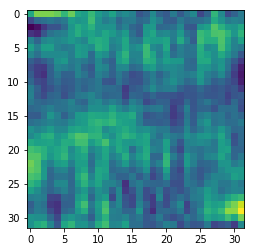

30
1.6022425623660123e-10


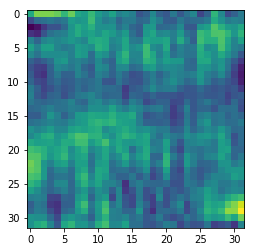

31
2.0386006080828766e-11


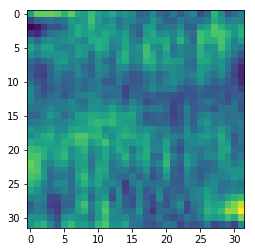

32
1.0796915183005948e-09


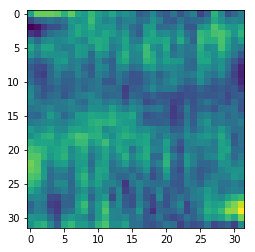

33
6.860548352952706e-10


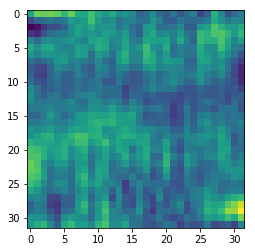

34
9.651545151819324e-11


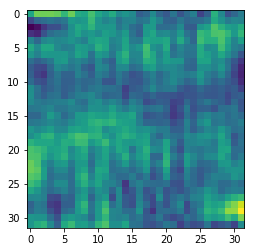

35
9.106382824710208e-10


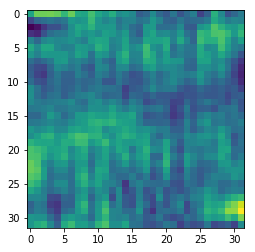

36
1.4957170633643963e-09


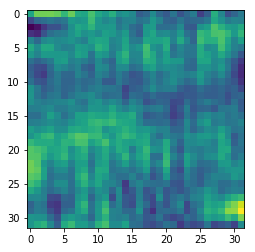

37
2.9172254030075864e-11


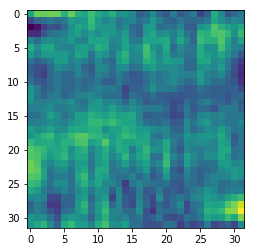

38
2.3449236849135877e-09


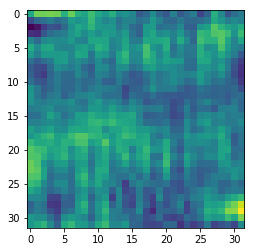

39
2.3543777026589913e-10


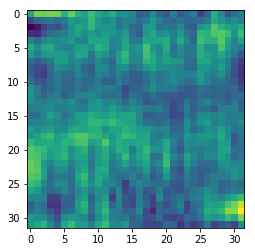

40
4.818248943949848e-10


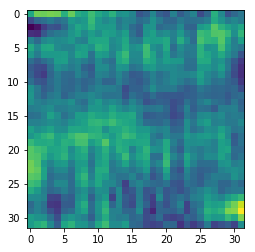

41
1.7231594801693465e-10


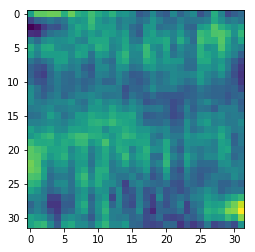

42
1.7701421069103176e-09


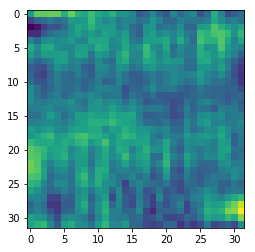

43
3.818946911358887e-10


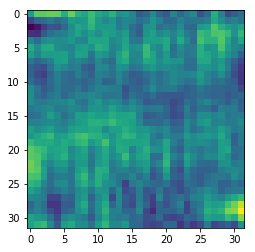

44
7.69658015328577e-11


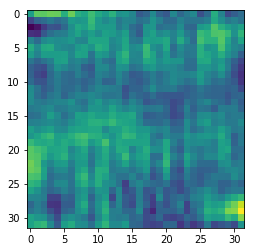

45
1.3580985276582016e-09


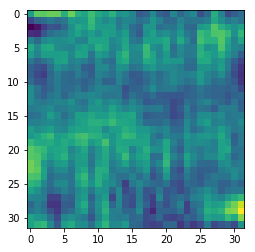

46
1.6297798858504023e-11


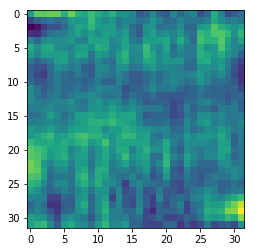

47
3.688813524359016e-10


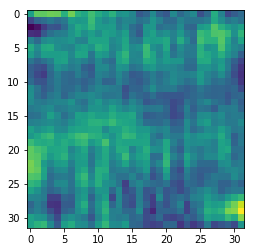

In [122]:
# solve for synthesized image using greedy algorithm

# target = x[0:n,0:n,0] 
# sx = np.mean(np.abs(wave_trans_in_freq_2d(target, psi_hat, True)),axis = (0,1))
# nx = target.shape
# y0 = np.random.random(nx[0]*nx[1]) #initialize y
# nw = psi_hat.shape[2] #number of wavelets
# ind = range(nw)
# ind = random.sample(ind,len(ind))

# for i in range(nw):
#     print(i)
#     y = least_squares(diff, y0, args = (sx[ind[0:i+1]], psi_hat[:,:,ind[0:i+1]],nx))
#     y0 = y.x
#     print(y.cost)
#     plt.imshow(np.reshape(y0, (n, n)))
#     plt.show()

In [16]:
target = x[0:n,0:n,0] # target: an image of size n x n
res = synthesis(target, psi_hat) # solve for synthesized image

4.4049657801672005e-11
5.847649508445707e-11
8.322986031017434e-13
1.1198563515914926e-11
3.1519708041352488e-12
3.4454960444982445e-11
3.892056862651657e-12
7.167926793846174e-11
4.6379840309556043e-11
8.376986889419252e-11
3.137403178888936e-11
9.948406727491065e-13
2.0018287126668783e-13
1.742135091022386e-11
1.9664006090218045e-10
3.5281175561144496e-11
1.6002466163546644e-10
1.0658850894393988e-11
2.7480494870739856e-11
5.264222849718785e-14
1.6647476898686918e-11
1.4805283811675803e-11
1.5694536107642274e-11
2.944527227712197e-12
2.442975686409901e-10
7.302574423260602e-11
7.73992314020203e-11
8.180641586972337e-11
4.834631894652462e-10
8.873576430178059e-11
7.63546071294842e-11
6.483056035275219e-11
3.372032755528796e-10
1.502755515219627e-10
8.076935917856113e-11
1.712023787556675e-10
4.534375369834676e-11
1.164754250209216e-09
5.055678130329273e-10
1.0568246624088933e-10
5.286816649922538e-10
4.947739849407637e-11
5.2906724214159345e-11
4.28637319096022e-10
4.537007304340487e-

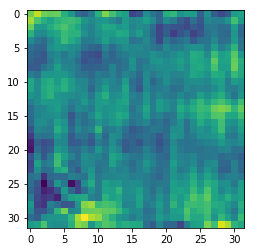

In [20]:
y = res.x
y = np.reshape(y,(32,32))
plt.imshow(y)

In [21]:
# wavelet coefficients of synthesized image
sy = np.mean(np.abs(wave_trans_in_freq_2d(y, psi_hat, True)),axis = (0,1))

# wavelet coefficients of target image
sx = np.mean(np.abs(wave_trans_in_freq_2d(target, psi_hat, True)),axis = (0,1)) 

In [22]:
# difference
sy - sx

array([-5.27596100e-08,  1.50095415e-07, -5.30825212e-07,  1.84632440e-06,
       -3.44671070e-06,  6.37404863e-06, -5.32540075e-06,  4.96239603e-06,
       -2.86555615e-08,  8.96762602e-08,  2.49431458e-07, -7.53719297e-07,
        2.48448646e-06, -1.05944080e-05,  2.06531704e-05, -2.45441631e-05,
        3.64725672e-08, -1.08474043e-07,  3.87780446e-07, -8.27753228e-07,
        9.99462355e-07,  9.03713424e-08, -1.16597418e-05,  1.63883139e-05,
        9.68726876e-09,  5.90022484e-08, -1.99066541e-07,  3.39660950e-07,
       -2.28551432e-07,  1.31812943e-07,  1.94639646e-06, -2.05449581e-06,
       -9.16242193e-10, -8.33320968e-08,  2.24677079e-07, -4.23749341e-07,
        3.08480903e-07, -2.21422574e-06,  1.14697359e-05, -1.47928238e-05,
       -2.62116346e-08,  1.11000021e-07, -3.67366488e-07,  1.05342090e-06,
       -1.66865430e-06,  1.29906988e-06, -1.29987471e-05,  2.07338601e-05])

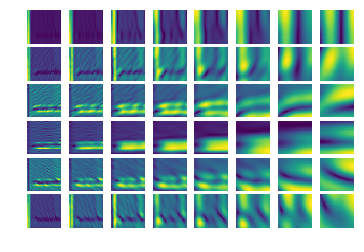

In [23]:
wx = wave_trans_in_freq_2d(target, psi_hat, True)
count = 0
for i in range(K):
    for k in range(S*Q):
        count += 1
        plt.subplot(K,S*Q,count)
        plt.imshow(np.abs(wx[:,:,count - 1]))
        plt.axis('off')
        
plt.subplots_adjust(hspace=0.1, wspace=0)
plt.show()

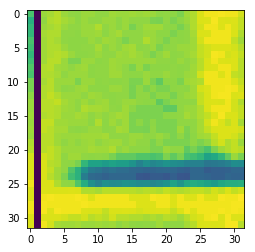

In [24]:
plt.imshow(target)